# PPE Detection with Pose Estimation
## Enhanced Compliance Detection: Wearing vs. Holding

**Author:** Zulfaqar  
**Project:** INF3001 Deep Learning - PPE Detection Enhancement  
**Model:** YOLOv8 (ppe-4080-v12) + MediaPipe Pose

---

This notebook demonstrates how to integrate pose estimation with your trained YOLOv8 PPE detection model to determine if workers are **wearing** PPE correctly or just **holding** it.

## Installation

Run this cell to install required packages:

In [ ]:
# Install required packages
!pip install ultralytics mediapipe opencv-python numpy 

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/ff/8b/d600709f9f802bdd3a7fe82645fc1e235999882009892592c9ae09510af9/ultralytics-8.3.230-py3-none-any.whl.metadata
  Obtaining dependency information for mediapipe from https://files.pythonhosted.org/packages/c5/1f/0b2bc80d76d996801113c800e386f7b33aeaec663e2e8ee83695c0dfbde8/mediapipe-0.10.21-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/fa/80/eb88edc2e2b11cd2dd2e56f1c80b5784d11d6e6b7f04a1145df64df40065/opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Obtaining dependency information for matplotlib>=3.3.0 from https://files.pythonhosted.org/packages/33/cd/b145f9797126f3f809d177ca378de57c45413c5099c5990de2658760594a/matplotlib-3.10.7-cp311-cp311-win_amd64.whl.metadata
  Using cached matplotlib-3.10.7-cp311-cp311-win_amd6


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Import Libraries and Initialize Detector

In [9]:
import cv2
import numpy as np
from ppe_pose_detector import HybridPPEPoseDetector
from IPython.display import Image, display
import matplotlib.pyplot as plt

# Set matplotlib to display inline
%matplotlib inline

## 2. Initialize the Enhanced PPE Detector

**Important:** Update the `model_path` to point to your trained YOLOv8 model.

In [7]:
# Path to your trained YOLOv8 model
# Update this path based on your project structure
model_path = '../ppe-4080-v12/weights/last.pt'

# Initialize detector
detector = HybridPPEPoseDetector(
    ppe_model_path='../ppe-4080-v12/weights/best.pt',
    confidence_threshold=0.5
)


print("✓ Detector initialized successfully!")
print(f"✓ YOLOv8 model loaded from: {model_path}")
print(f"✓ MediaPipe Pose initialized")

HYBRID PPE POSE DETECTOR - DUAL MODEL SYSTEM

[1/3] Loading YOLOv8n (pretrained) for person detection...
      ✓ Person detection model ready!

[2/3] Loading YOUR PPE model from: ../ppe-4080-v12/weights/best.pt
      ✓ PPE detection model loaded!
      PPE Model classes: ['Fall-Detected', 'Gloves', 'Goggles', 'Hardhat', 'Ladder', 'Mask', 'NO-Gloves', 'NO-Goggles', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest']

[3/3] Initializing MediaPipe Pose...
      ✓ MediaPipe Pose initialized!

INITIALIZATION COMPLETE!

✓ Detector initialized successfully!
✓ YOLOv8 model loaded from: ../ppe-4080-v12/weights/last.pt
✓ MediaPipe Pose initialized


## 3. Understanding How It Works

### Pipeline Overview:

```
Input Frame
    ↓
Step 1: YOLOv8 Detection
    → Detect: people, helmets, vests, etc.
    ↓
Step 2: Pose Estimation (MediaPipe)
    → Extract body keypoints: head, hands, torso
    ↓
Step 3: Spatial Analysis
    → Calculate distances between PPE and body parts
    ↓
Step 4: Compliance Decision
    → Helmet < 60px from head → WEARING ✓
    → Helmet < 100px from hand → HOLDING ✗
    → Vest overlaps torso → WEARING ✓
```

## 4. Process a Single Image

Let's test the detector on a sample construction site image.

[Detection] Found 3 people
[Detection] Found 0 helmets, 0 vests

DETECTION RESULTS
Total People Detected: 3
Compliant Workers: 0
Non-Compliant Workers: 3
Compliance Rate: 0.0%


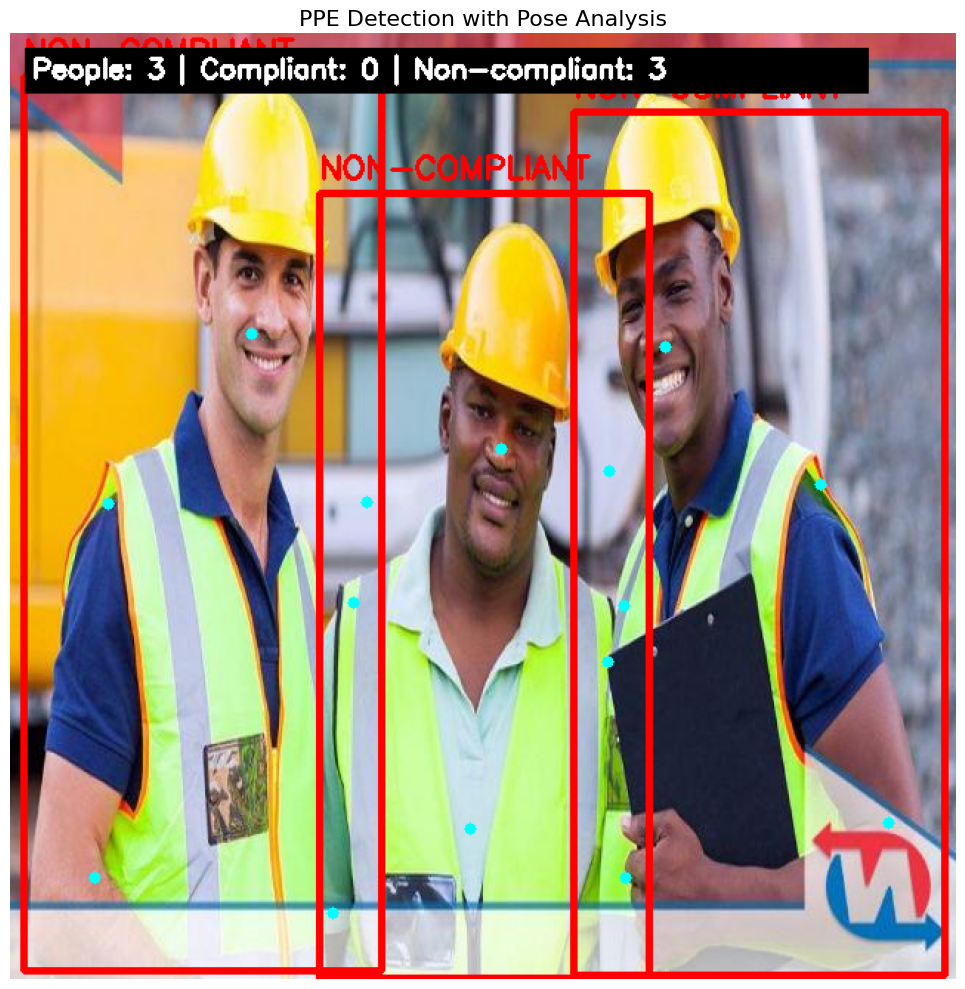

In [8]:
# Load test image
# Replace with your test image path
test_image_path = '../dataset/train/helmet/57.jpg'

frame = cv2.imread(test_image_path)

if frame is None:
    print(f"❌ Error: Could not load image from {test_image_path}")
    print("Please update the path to a valid test image.")
else:
    # Process the frame
    output_frame, results = detector.process_frame(frame, visualize=True)
    
    # Display results
    print("\n" + "="*60)
    print("DETECTION RESULTS")
    print("="*60)
    print(f"Total People Detected: {results['total_people']}")
    print(f"Compliant Workers: {results['compliant_people']}")
    print(f"Non-Compliant Workers: {results['non_compliant_people']}")
    print(f"Compliance Rate: {results['compliance_rate']*100:.1f}%")
    print("="*60)
    
    # Show the annotated image
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
    plt.title('PPE Detection with Pose Analysis', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## 5. Detailed Analysis Per Person

Let's examine the detailed analysis for each detected person:

In [15]:
# Print detailed analysis for each person
for i, person in enumerate(results['person_analyses'], 1):
    print(f"\n{'='*60}")
    print(f"PERSON {i}")
    print(f"{'='*60}")
    
    print(f"Pose Detected: {person['pose_detected']}")
    print(f"Overall Compliance: {'✓ COMPLIANT' if person['overall_compliant'] else '✗ NON-COMPLIANT'}")
    
    # Helmet status
    if person['helmet_status']:
        print(f"\nHelmet Status: {person['helmet_status']['status']}")
        print(f"  - {person['helmet_status']['reason']}")
        if 'distances' in person['helmet_status']:
            print(f"  - Distance to head: {person['helmet_status']['distances']['to_head']:.1f}px")
            print(f"  - Distance to left hand: {person['helmet_status']['distances']['to_left_hand']:.1f}px")
            print(f"  - Distance to right hand: {person['helmet_status']['distances']['to_right_hand']:.1f}px")
    
    # Vest status
    if person['vest_status']:
        print(f"\nVest Status: {person['vest_status']['status']}")
        print(f"  - {person['vest_status']['reason']}")
    
    # Warnings
    if person['warnings']:
        print(f"\nWarnings:")
        for warning in person['warnings']:
            print(f"  ⚠ {warning}")
    
    print(f"{'='*60}")


PERSON 1
Pose Detected: True
Overall Compliance: ✗ NON-COMPLIANT

Helmet Status: WEARING
  - Helmet on head (distance: 24.7px)
  - Distance to head: 24.7px
  - Distance to left hand: 134.7px
  - Distance to right hand: 147.3px

Vest Status: NOT_DETECTED
  - No vest detected near person

Warnings:
  ⚠ Vest: No vest detected near person

PERSON 2
Pose Detected: True
Overall Compliance: ✗ NON-COMPLIANT

Helmet Status: WEARING
  - Helmet on head (distance: 39.1px)
  - Distance to head: 39.1px
  - Distance to left hand: 158.3px
  - Distance to right hand: 167.1px

Vest Status: NOT_DETECTED
  - No vest detected near person

Warnings:
  ⚠ Vest: No vest detected near person


## 6. Visualize Pose Keypoints

Let's visualize the detected body keypoints for better understanding:

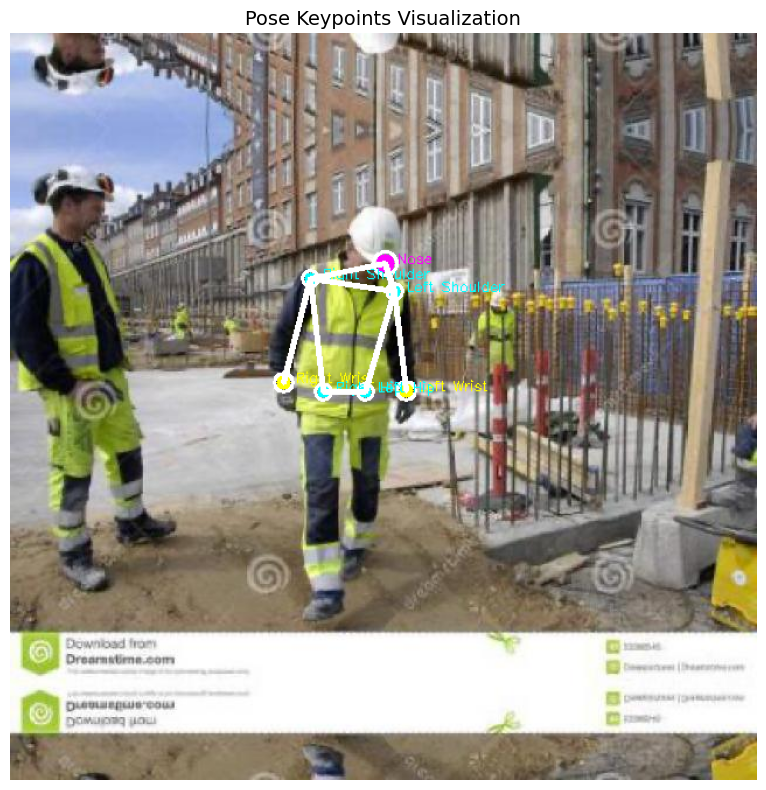

In [16]:
def visualize_pose_keypoints(frame, person_analysis):
    """
    Create a detailed visualization of pose keypoints
    """
    if not person_analysis['pose_detected']:
        print("No pose detected for this person")
        return
    
    vis_frame = frame.copy()
    pose_data = person_analysis['pose_data']
    
    # Define colors for different body parts
    colors = {
        'head': (255, 0, 255),      # Magenta
        'hands': (0, 255, 255),     # Cyan
        'torso': (255, 255, 0),     # Yellow
    }
    
    # Draw keypoints
    keypoint_info = [
        ('nose', 'head', 8),
        ('left_wrist', 'hands', 6),
        ('right_wrist', 'hands', 6),
        ('left_shoulder', 'torso', 5),
        ('right_shoulder', 'torso', 5),
        ('left_hip', 'torso', 5),
        ('right_hip', 'torso', 5),
    ]
    
    for kp_name, color_key, radius in keypoint_info:
        if kp_name in pose_data:
            pt = pose_data[kp_name]
            cv2.circle(vis_frame, pt, radius, colors[color_key], -1)
            cv2.circle(vis_frame, pt, radius+2, (255, 255, 255), 2)
            # Add label
            cv2.putText(vis_frame, kp_name.replace('_', ' ').title(), 
                       (pt[0]+10, pt[1]), cv2.FONT_HERSHEY_SIMPLEX, 
                       0.4, colors[color_key], 1)
    
    # Draw skeleton
    skeleton = [
        ('left_shoulder', 'right_shoulder'),
        ('left_shoulder', 'left_hip'),
        ('right_shoulder', 'right_hip'),
        ('left_hip', 'right_hip'),
        ('nose', 'left_shoulder'),
        ('nose', 'right_shoulder'),
        ('left_shoulder', 'left_wrist'),
        ('right_shoulder', 'right_wrist'),
    ]
    
    for start, end in skeleton:
        if start in pose_data and end in pose_data:
            cv2.line(vis_frame, pose_data[start], pose_data[end], 
                    (255, 255, 255), 3)
    
    return vis_frame

# Visualize pose for first person
if results['person_analyses']:
    pose_vis = visualize_pose_keypoints(frame, results['person_analyses'][0])
    
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(pose_vis, cv2.COLOR_BGR2RGB))
    plt.title('Pose Keypoints Visualization', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No people detected in the image")

## 7. Process Video (Optional)

Process a video file and save the annotated output:

In [ ]:
# Process video (uncomment to use)
# video_path = 'test_videos/construction_site.mp4'
# output_path = 'output_videos/ppe_detected.mp4'

# detector.process_video(
#     video_path=video_path,
#     output_path=output_path,
#     display=False  # Set to True to see real-time processing
# )

# print(f"Video processed and saved to: {output_path}")

## 8. Real-time Webcam Detection (Optional)

Test the detector with your webcam:

In [ ]:
# Start webcam detection (uncomment to use)
# NOTE: This works best in a regular Python script, not Jupyter
# detector.process_webcam()

print("Webcam detection is better run from a Python script.")
print("Use: python ppe_pose_detector.py --model <model_path> --source webcam")

## 9. Export Results to JSON

Save detailed results for further analysis:

In [ ]:
import json

# Save results to JSON
output_json = 'detection_results.json'
detector.save_results_json(results, output_json)

# Load and display
with open(output_json, 'r') as f:
    saved_results = json.load(f)

print("\nSaved Results Summary:")
print(json.dumps({
    'total_people': saved_results['total_people'],
    'compliant_people': saved_results['compliant_people'],
    'compliance_rate': f"{saved_results['compliance_rate']*100:.1f}%"
}, indent=2))

## 10. Configuration & Tuning

Adjust detection thresholds based on your needs:

In [ ]:
# Access and modify thresholds
print("Current Thresholds:")
print(f"  Helmet to Head: {detector.HELMET_HEAD_THRESHOLD}px")
print(f"  Helmet to Hand: {detector.HELMET_HAND_THRESHOLD}px")
print(f"  Vest to Torso: {detector.VEST_TORSO_THRESHOLD}px")

# Modify thresholds if needed
# detector.HELMET_HEAD_THRESHOLD = 70  # More lenient
# detector.HELMET_HAND_THRESHOLD = 80  # More strict

## 11. Understanding the Logic

### How Detection Works:

#### Helmet Detection Logic:
```python
# Calculate distances
dist_to_head = distance(helmet_center, nose_keypoint)
dist_to_left_hand = distance(helmet_center, left_wrist)
dist_to_right_hand = distance(helmet_center, right_wrist)

# Decision
if dist_to_head < 60px:
    status = "WEARING"  # ✓
elif dist_to_left_hand < 100px or dist_to_right_hand < 100px:
    status = "HOLDING"  # ✗
else:
    status = "NEARBY"   # ✗
```

#### Vest Detection Logic:
```python
# Calculate torso center from shoulders and hips
torso_center = average(left_shoulder, right_shoulder, left_hip, right_hip)
dist_to_torso = distance(vest_center, torso_center)

# Check if vest is in torso Y-range
is_in_torso_region = (shoulder_y <= vest_y <= hip_y)

if dist_to_torso < 120px and is_in_torso_region:
    status = "WEARING"  # ✓
else:
    status = "NOT_WEARING"  # ✗
```

## 12. Performance Tips

### Optimization Strategies:

1. **Skip Pose Estimation for Compliant Detections:**
   - If YOLOv8 doesn't detect 'no-hardhat', assume compliance
   - Only run pose estimation when there's ambiguity

2. **Process Every N Frames for Video:**
   - For real-time, process every 2-3 frames
   - Interpolate results for skipped frames

3. **Use Lower Resolution:**
   - Resize frames to 640x480 before processing
   - Scale detection boxes back to original size

4. **Batch Processing:**
   - Process multiple frames in a batch
   - Utilize GPU more efficiently

## 13. Integration with Your FastAPI Backend

Here's how to integrate this into your existing FastAPI web app:

In [ ]:
# Example FastAPI endpoint (save this in your backend/main.py)
"""
from fastapi import FastAPI, UploadFile, File
from ppe_pose_detector import PPEPoseDetector
import cv2
import numpy as np

app = FastAPI()
detector = PPEPoseDetector('runs/detect/ppe-4080-v12/weights/best.pt')

@app.post("/detect-ppe-pose/")
async def detect_ppe_with_pose(file: UploadFile = File(...)):
    # Read uploaded file
    contents = await file.read()
    nparr = np.frombuffer(contents, np.uint8)
    frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    # Process frame
    output_frame, results = detector.process_frame(frame, visualize=True)
    
    # Encode output image
    _, buffer = cv2.imencode('.jpg', output_frame)
    
    return {
        'total_people': results['total_people'],
        'compliant_people': results['compliant_people'],
        'compliance_rate': results['compliance_rate'],
        'details': results['person_analyses']
    }
"""

print("FastAPI integration code displayed above.")
print("Add this to your backend/main.py file.")

## Summary

### What We've Built:

✓ **Enhanced PPE Detection System** that goes beyond simple object detection  
✓ **Pose-Based Compliance Verification** to distinguish wearing vs. holding  
✓ **Spatial Analysis** using body keypoints and PPE positions  
✓ **Real-time Processing** for images, videos, and webcam  
✓ **Comprehensive Reporting** with detailed per-person analysis  

### Key Advantages:

1. **No Training Required** - Uses pre-trained MediaPipe Pose
2. **Works with Your Model** - Integrates seamlessly with your YOLOv8 model
3. **Accurate Compliance** - Reduces false positives from people just carrying PPE
4. **Explainable** - Provides spatial reasoning for each decision

### Next Steps:

1. Test with your construction site images
2. Tune threshold parameters for your use case
3. Integrate into your FastAPI backend
4. Deploy and collect real-world performance metrics

---

**Project by:** Zulfaqar  
**Course:** INF3001 Deep Learning  
**Institution:** Singapore Institute of Technology